# Streaming

In [3]:

%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk

In [4]:
import os
from dotenv import load_dotenv
load_dotenv()

True

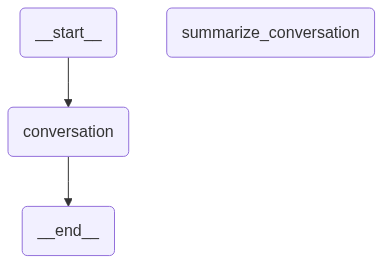

In [5]:
from IPython.display import Image, display

from langchain_groq import ChatGroq
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.runnables import RunnableConfig

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

# LLM
model = ChatGroq(model=os.getenv("GROQ_MODEL_NAME"), temperature=0) 

# State 
class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State, config: RunnableConfig):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages, config)
    return {"messages": response}

def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

### Streaming full state

![img](https://camo.githubusercontent.com/7a901c7fd93722f1ae8d1412d1d52c35b979662d137e98a33444c86fa4ffc433/68747470733a2f2f63646e2e70726f642e776562736974652d66696c65732e636f6d2f3635623863643732383335636565616364343434396135332f3636646261663839326432343632356132303137343465355f73747265616d696e67312e706e67)

In [6]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Pandhari")]}, config, stream_mode="updates"):
    print(chunk)

{'conversation': {'messages': AIMessage(content="Hello Pandhari, it's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 41, 'total_tokens': 68, 'completion_time': 0.098181818, 'prompt_time': 0.002581172, 'queue_time': 0.058350588, 'total_time': 0.10076299}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_2ddfbb0da0', 'finish_reason': 'stop', 'logprobs': None}, id='run--d39f3411-1c5e-4802-a4bd-95003e5310bc-0', usage_metadata={'input_tokens': 41, 'output_tokens': 27, 'total_tokens': 68})}}


In [7]:
# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Pandhari")]}, config, stream_mode="updates"):
    chunk['conversation']["messages"].pretty_print()

================================== Ai Message ==================================

Hello again, Pandhari. How's your day going so far? Is there something on your mind that you'd like to talk about, or would you like some recommendations or fun facts? I'm all ears!


In [8]:
# Start conversation, again
config = {"configurable": {"thread_id": "2"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Pandhari")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("---"*25)

================================ Human Message =================================

hi! I'm Pandhari
---------------------------------------------------------------------------
================================ Human Message =================================

hi! I'm Pandhari
================================== Ai Message ==================================

Hello Pandhari, it's nice to meet you. Is there something I can help you with or would you like to chat?
---------------------------------------------------------------------------


### Streaming tokens

In [9]:
config = {"configurable": {"thread_id": "3"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    print(f"Node: {event['metadata'].get('langgraph_node','')}. Type: {event['event']}. Name: {event['name']}")

Node: . Type: on_chain_start. Name: LangGraph
Node: conversation. Type: on_chain_start. Name: conversation
Node: conversation. Type: on_chat_model_start. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conver

In [10]:
node_to_stream = 'conversation'
config = {"configurable": {"thread_id": "4"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        print(event["data"])

{'chunk': AIMessageChunk(content='', additional_kwargs={}, response_metadata={}, id='run--74d6bcb1-26b0-43c3-a195-0365d6aadbe0')}
{'chunk': AIMessageChunk(content='The', additional_kwargs={}, response_metadata={}, id='run--74d6bcb1-26b0-43c3-a195-0365d6aadbe0')}
{'chunk': AIMessageChunk(content=' San', additional_kwargs={}, response_metadata={}, id='run--74d6bcb1-26b0-43c3-a195-0365d6aadbe0')}
{'chunk': AIMessageChunk(content=' Francisco', additional_kwargs={}, response_metadata={}, id='run--74d6bcb1-26b0-43c3-a195-0365d6aadbe0')}
{'chunk': AIMessageChunk(content=' ', additional_kwargs={}, response_metadata={}, id='run--74d6bcb1-26b0-43c3-a195-0365d6aadbe0')}
{'chunk': AIMessageChunk(content='49', additional_kwargs={}, response_metadata={}, id='run--74d6bcb1-26b0-43c3-a195-0365d6aadbe0')}
{'chunk': AIMessageChunk(content='ers', additional_kwargs={}, response_metadata={}, id='run--74d6bcb1-26b0-43c3-a195-0365d6aadbe0')}
{'chunk': AIMessageChunk(content=' are', additional_kwargs={}, resp

In [11]:
config = {"configurable": {"thread_id": "5"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        data = event["data"]
        print(data["chunk"].content, end="|")

|The| San| Francisco| |49|ers| are| a| professional| American| football| team| based| in| the| San| Francisco| Bay| Area| of| California|.| They| are| a| member| of| the| West| division| of| the| National| Football| Conference| (|N|FC|)| in| the| National| Football| League| (|NFL|).| Here| are| some| key| facts| about| the| team|:

|**|History|**:| The| |49|ers| were| founded| in| |194|6| as| a| charter| member| of| the| All|-Americ|a| Football| Conference| (|AA|FC|).| They| joined| the| NFL| in| |195|0| after| the| AA|FC| merged| with| the| NFL|.| The| team| was| named| after| the| California| Gold| Rush| of| |184|9|,| which| drew| thousands| of| prospect|ors| to| the| area|.

|**|Home| Stadium|**:| The| |49|ers| play| their| home| games| at| Levi|'s| Stadium| in| Santa| Clara|,| California|,| which| is| located| about| |45| miles| south| of| San| Francisco|.| The| stadium| has| a| seating| capacity| of| over| |68|,|000| and| features| state|-of|-the|-art| amenities|.

|**|Team| Color

In [12]:
from langgraph_sdk import get_client

# This is the URL of the local development server
URL = "http://127.0.0.1:2024"
client = get_client(url=URL)

# Search all hosted graphs
assistants = await client.assistants.search()

In [13]:
# Create a new thread
thread = await client.threads.create()
# Input message
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="agent", 
                                      input={"messages": [input_message]}, 
                                      stream_mode="values"):
    print(event)

StreamPart(event='metadata', data={'run_id': '1f02f726-534e-6fe2-aa59-266cb5e98fb3', 'attempt': 1})
StreamPart(event='values', data={'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '77b52f13-e0a5-4905-a980-9a9444af3f54', 'example': False}]})
StreamPart(event='values', data={'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '77b52f13-e0a5-4905-a980-9a9444af3f54', 'example': False}, {'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_y55m', 'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'token_usage': {'completion_tokens': 19, 'prompt_tokens': 374, 'total_tokens': 393, 'completion_time': 0.069090909, 'prompt_time': 0.030538134, 'queue_time': 0.055066596, 'total_time': 0.099629043}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp

In [14]:
from langchain_core.messages import convert_to_messages
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(thread["thread_id"], assistant_id="agent", input={"messages": [input_message]}, stream_mode="values"):
    messages = event.data.get('messages',None)
    if messages:
        print(convert_to_messages(messages)[-1])
    print('='*25)

content='Multiply 2 and 3' additional_kwargs={} response_metadata={} id='3493e6d5-0791-46d0-9f8e-c60a7c15d56c'
content='' additional_kwargs={'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 374, 'output_tokens': 19, 'total_tokens': 393}, 'tool_calls': [{'id': 'call_fmsm', 'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'multiply'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 374, 'total_tokens': 393, 'completion_time': 0.069090909, 'prompt_time': 0.025557477, 'queue_time': 0.055158363, 'total_time': 0.094648386}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_2ddfbb0da0', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--c39c8a28-cbf1-4670-9de9-341074d24013-0' tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_fmsm', 'type': 'tool_call'}]
content='6' name='multiply' id='66ef1345-3e9d-41b1-82e0-22c13499cd6c' tool_call_id='call_fmsm'
content='The result of multiplying 

In [15]:
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="agent", 
                                      input={"messages": [input_message]}, 
                                      stream_mode="messages"):
    print(event.event)

metadata
messages/metadata
messages/partial
messages/partial
messages/partial
messages/metadata
messages/complete
messages/metadata
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial


In [16]:
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")

def format_tool_calls(tool_calls):
    """
    Format a list of tool calls into a readable string.

    Args:
        tool_calls (list): A list of dictionaries, each representing a tool call.
            Each dictionary should have 'id', 'name', and 'args' keys.

    Returns:
        str: A formatted string of tool calls, or "No tool calls" if the list is empty.

    """

    if tool_calls:
        formatted_calls = []
        for call in tool_calls:
            formatted_calls.append(
                f"Tool Call ID: {call['id']}, Function: {call['name']}, Arguments: {call['args']}"
            )
        return "\n".join(formatted_calls)
    return "No tool calls"

async for event in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input={"messages": [input_message]},
    stream_mode="messages",):
    
    # Handle metadata events
    if event.event == "metadata":
        print(f"Metadata: Run ID - {event.data['run_id']}")
        print("-" * 50)
    
    # Handle partial message events
    elif event.event == "messages/partial":
        for data_item in event.data:
            # Process user messages
            if "role" in data_item and data_item["role"] == "user":
                print(f"Human: {data_item['content']}")
            else:
                # Extract relevant data from the event
                tool_calls = data_item.get("tool_calls", [])
                invalid_tool_calls = data_item.get("invalid_tool_calls", [])
                content = data_item.get("content", "")
                response_metadata = data_item.get("response_metadata", {})

                if content:
                    print(f"AI: {content}")

                if tool_calls:
                    print("Tool Calls:")
                    print(format_tool_calls(tool_calls))

                if invalid_tool_calls:
                    print("Invalid Tool Calls:")
                    print(format_tool_calls(invalid_tool_calls))

                if response_metadata:
                    finish_reason = response_metadata.get("finish_reason", "N/A")
                    print(f"Response Metadata: Finish Reason - {finish_reason}")
                    
        print("-" * 50)

Metadata: Run ID - 1f02f72a-916c-6442-bcaf-221f89cc4789
--------------------------------------------------
--------------------------------------------------
Tool Calls:
Tool Call ID: call_bzz2, Function: multiply, Arguments: {'a': 2, 'b': 3}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_bzz2, Function: multiply, Arguments: {'a': 2, 'b': 3}
Response Metadata: Finish Reason - tool_calls
--------------------------------------------------
--------------------------------------------------
AI: The
--------------------------------------------------
AI: The result
--------------------------------------------------
AI: The result of
--------------------------------------------------
AI: The result of multiplying
--------------------------------------------------
AI: The result of multiplying 
--------------------------------------------------
AI: The result of multiplying 2
--------------------------------------------------
AI: The result of multiplying 2 a